In [75]:
###########################################################################
# Copyright 2022 Jean-Luc CHARLES
# Created: 2022-07-29
# version: 1.0 
# License: GNU GPL-3.0-or-later
###########################################################################

# <img align="left" src="./images/movie_camera.png" width="40" height="40"> Use the _Deep Reinforcement Lerning_ (DRL) to train a Nneural Network (NN) to the control robot position.algorithm

In this activity you will learn how to use the DRL approach to train a ___PPO___  neural network to control the robot position.

# <img align="left" src="./images/film_reel.png" width="40" height="40">$\,$Outline <a name="top"></a>
- [ 1 - The class RoboticArm_2DOF](#1)
    - [ 1.1 - Instancite the robot](#1.1)
    - [ 1.2 - Run a simple test](#1.2)
- [ 2 - Train the PPO neural network](#2)
    - [ 2.1 - ](#2.1)
    - [ 2.2 - ](#2.2)
- [ 3 - ](#3)
    - [ 3.1 - ](#3.1)
    - [ 3.2 - ](#3.2)
- [ 4 - ](#4)
    - [ 4.1 ](#4.1)
    - [ 4.2 ](#4.2)

Recommended links:
- Pybullet online documentation: [PyBullet Quickstart Guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.2ye70wns7io3)

# Import the required modules

In [1]:
import os, sys, time, shutil, yaml, pathlib, shutil
import pybullet as p
import pybullet_data
import numpy as np
import matplotlib.pyplot as plt
from math import pi

from utils.tools import is_close_to, move_to, display_joint_properties
from utils.tools import welcome, plot_test, moving_average
from utils.RoboticArm_2DOF import RoboticArm_2DOF_PyBullet
pc = None

# 1. The class RoboticArm_2DOF<a name="1"></a><a name="1"></a>
## 1.1 - Instanciate the robot<a name="1.1"></a><a name="1.1"></a>

In [2]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

env    = RoboticArm_2DOF_PyBullet(robot_urdf = URDF, 
                                  target_urdf = TARGET, 
                                  dt = 0.002,
                                  headless = None, 
                                  verbose=0)


################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#    G: close/open the tabs
#    W: switch between solid/wireframe rendering
#    J: show/hide links & joints frames as RGB lines (with wireframe rendering actvated)
#    K: show/hide joint axes as a black line         (with wireframe rendering actvated)
#    A: show/hide collision boxes                    (with wireframe rendering actvated)
#    CTRL+left_clic  : rotate the robot
#    CRTL+midlle_clic: translate the robot
#    Mouse_wheel: zoom/unzoom
################################################################################



/home/jlc/work/miniconda3/envs/pyml/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 1.2 - Run a simple test<a name="1.2"></a>

In this test, the two DOFs of the robot $q_1$ and $q_2$ arre controlled by position to make the robot move around its start position.

In [3]:
data = env.testAngleControl(0.075)
input("press ENTER to end....")
env.close()    

[testAngleControl] Ready to run the test with timestep=7.50e-02 s


[testAngleControl] Press ENTER to launch the free run simulation... 


sub_steps: 2
[1.9722144603729248, 0.0005584661266766489, -2.443467855453491, 0.0005152584053575993, 0.3675534427165985, 0.5229070782661438, 0.5002757906913757, 0.4865032434463501]
3.83°[2.0386641025543213, 0.02549746073782444, -2.5099034309387207, -0.025489438325166702, 0.3675534427165985, 0.5229070782661438, 0.44005629420280457, 0.45855826139450073]
7.61°[2.1046957969665527, 0.025331681594252586, -2.575935125350952, -0.025373123586177826, 0.3675534427165985, 0.5229070782661438, 0.3821451663970947, 0.42685776948928833]
11.31°[2.1692283153533936, 0.024761756882071495, -2.6404669284820557, -0.024758584797382355, 0.3675534427165985, 0.5229070782661438, 0.3276897072792053, 0.3922506272792816]
14.88°[2.2315285205841064, 0.02392209693789482, -2.7027673721313477, -0.023893136531114578, 0.3675534427165985, 0.5229070782661438, 0.27733978629112244, 0.35557472705841064]
18.28°[2.2908904552459717, 0.02277827449142933, -2.762129783630371, -0.02276885136961937, 0.3675534427165985, 0.5229070782661438

press ENTER to end.... 


#### Plot the data:

We can verify that tha actual values of $q_1$ and $q_2$ are close to the tagrte values (dashed black lines).

Also we can draw the velocities $\dot{q}_1$ and $\dot{q}_2$, as well as the trajectory of the end effcetor of the robot:

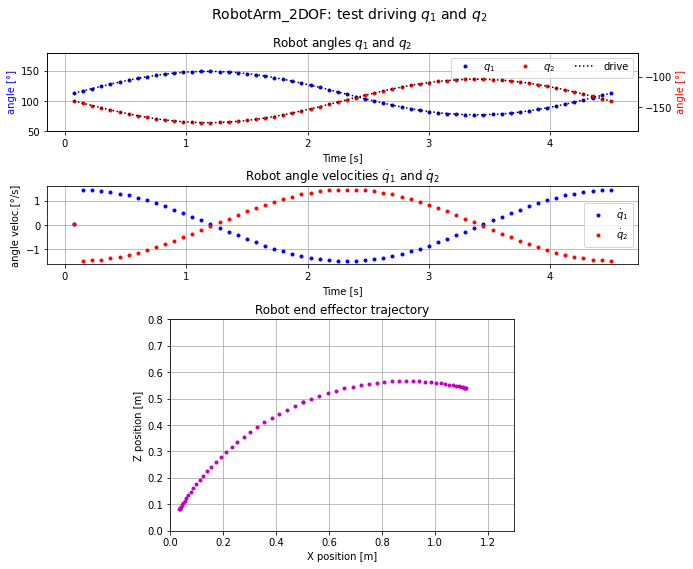

In [4]:
data = data.astype(float)
plot_test(data)

[top](#top)

# 2 - Train the PPO neural network<a name="2"></a>

#### Training Strategy

The training of the robot involves a loop on the traget position:
- A target is choosen at a random position in the space reachable by the robot.
- During the training, the reward function encourages the robot to move its end effector as close as possible to the target position.
- When done (the end effector is close to the target), a new target position is randomly choosen, and so on...

The whole training process is driven by __hyperparameters__. For example :
- `N_target_pos`: the total number of random positions learned before we decide that the network is trained.
- `epsilon_target`: the distance between the end effector mass center and the target mass center below which the effector is considered close enough to the target.
- `n_epoch`: the (classical) number of training runs with the same data set


## 2.1 The configuration files <a name="2.1"></a>

We use different configuration files to store:

- the parameters that define the robot
- the parameters that cbnfigure the neural network 
- hyperparameters used for the training itsefl.

## 2.2 Instanciate the robot <a name="2.2"></a>

The class `RoboticArm_2DOF_PyBullet` inherits from the class `env` of the frmawork _Gym_.

In [1]:
import os, sys, time, shutil, yaml, pathlib, shutil
import pybullet as p
import pybullet_data
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from math import pi

from utils.tools import is_close_to, move_to, display_joint_properties, test_training, sample_line, sample_traj4pts
from utils.tools import welcome, plot_test, moving_average
from utils.RoboticArm_2DOF import RoboticArm_2DOF_PyBullet

pybullet build time: May 20 2022 19:44:17


In [2]:
DT = 0.002

In [3]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"
SEED = 1234567
env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  init_target_pos = (0.5, 0, 0.5),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  epsilon= 1e-3,
                                  headless = True, 
                                  max_episode_steps = 500,
                                  verbose=1)

env.action_space.seed(SEED)
env.observation_space.seed(SEED)

[RoboticArm_2DOF_PyBullet.__init__] _max_episode_steps:500


/home/jlc/work/miniconda3/envs/pyml38/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


[1234567]

In [4]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})
obs

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0


array([ 2.2991273 ,  0.        , -2.681301  ,  0.        ,  1.0035251 ,
        0.23244807,  0.26225692,  0.3934123 ], dtype=float32)

In [ ]:
obs = env.reset(options={"target_initial_pos":(0.50, 0, 0.50), 'randomize':True})
obs

[RoboticArm_2DOF_PyBullet.reset] last #steps : 0

joints_pos: (1.497053187781225, -2.539355827537)
joints_veloc.: (-4.472905803484161e-06, -0.04045789871676141)


array([ 1.4970531 ,  0.        , -2.5393558 ,  0.        ,  0.83687365,
        0.6502507 ,  0.57791084,  0.15371545], dtype=float32)

In [4]:
env.close()

## 2.3 Instanciate the PPO network <a name="2.3"></a>

#### PPO hyperparameters:

In [5]:
policy = 'MlpPolicy'
tot_steps  = 5000000
save_freq  = 100000
nb_steps   = 2048        # The number of steps to run per update (the size of the rollout buffer)
nb_epochs  = 10
batch_size = 256
seed       = SEED
headless   = True

#### Other parameters:

In [6]:
environment = '2DOF_RobotArm_PyBullet'
agent_type  = 'PPO'

#### Directories:

In [7]:
experiment_time = time.localtime()
experiment_id = "_".join([environment, agent_type,
                         time.strftime("%y-%m-%d_%H-%M-%S", experiment_time)])
training_dir = pathlib.Path('models')/experiment_id
training_dir.mkdir(parents=True, exist_ok=True)

In [8]:
from stable_baselines3 import PPO as agent
from stable_baselines3.common.callbacks import CheckpointCallback

model = agent(policy, 
              env, 
              n_epochs=nb_epochs,
              n_steps=nb_steps,
              batch_size=batch_size,
              use_sde=False,
              seed=seed,
              tensorboard_log=training_dir,
              verbose=1)

checkpoint_callback = CheckpointCallback(save_freq=save_freq, 
                                         save_path=training_dir/'ZIP')

# train agent
t0 = time.time()

model.learn(total_timesteps=tot_steps, 
            callback=checkpoint_callback)
    
t = int(time.time()-t0)
h = int(t//3600)
m = int((t - h*3600)//60)
print(f"Training elapsed time: {h:02d}h {m:02d}m")
  
# save trained agent
target_zip = os.path.join(training_dir, 'ZIP', 'model.zip')
print(f"saving trained model in <{target_zip}>")
model.save(target_zip)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[RoboticArm_2DOF_PyBullet.reset] last #steps : 0
Logging to models/2DOF_RobotArm_PyBullet_PPO_22-09-26_17-56-23/PPO_1
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 0.812    |
| time/              |          |
|    fps             | 753      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
[RoboticArm_2DOF_PyBullet.reset] last #steps : 500
----------------------------------------

In [9]:
t1=np.array(env.torque1)
t2=np.array(env.torque2)

In [10]:
t1.mean(), t2.mean()

(-0.022759153, 0.0041485885)

In [11]:
(t2==1).sum() +(t2==-1).sum()

235621

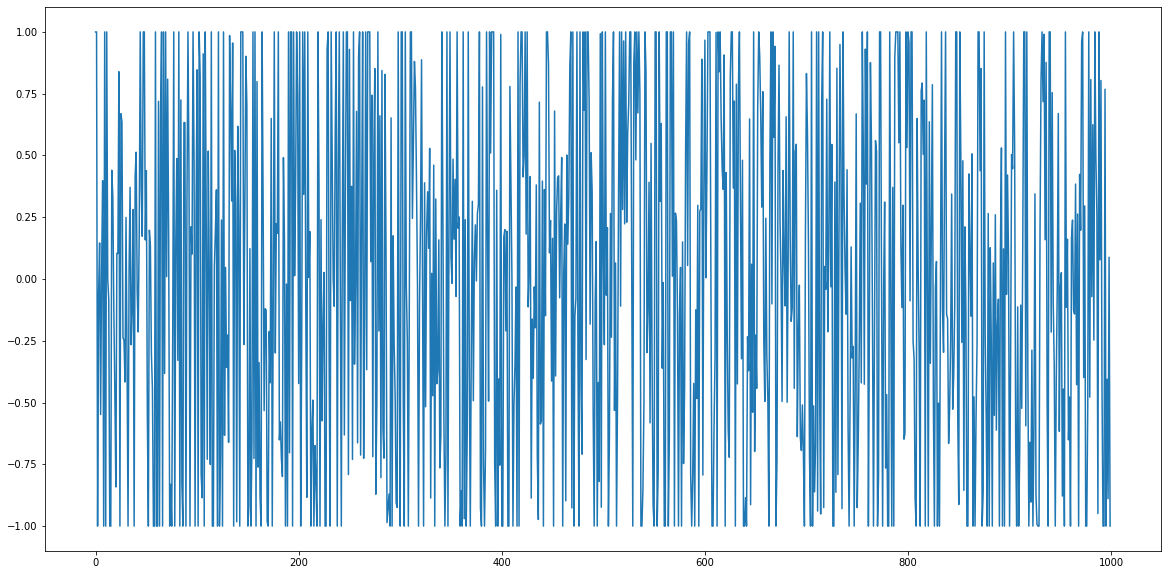

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(t1[:1000])

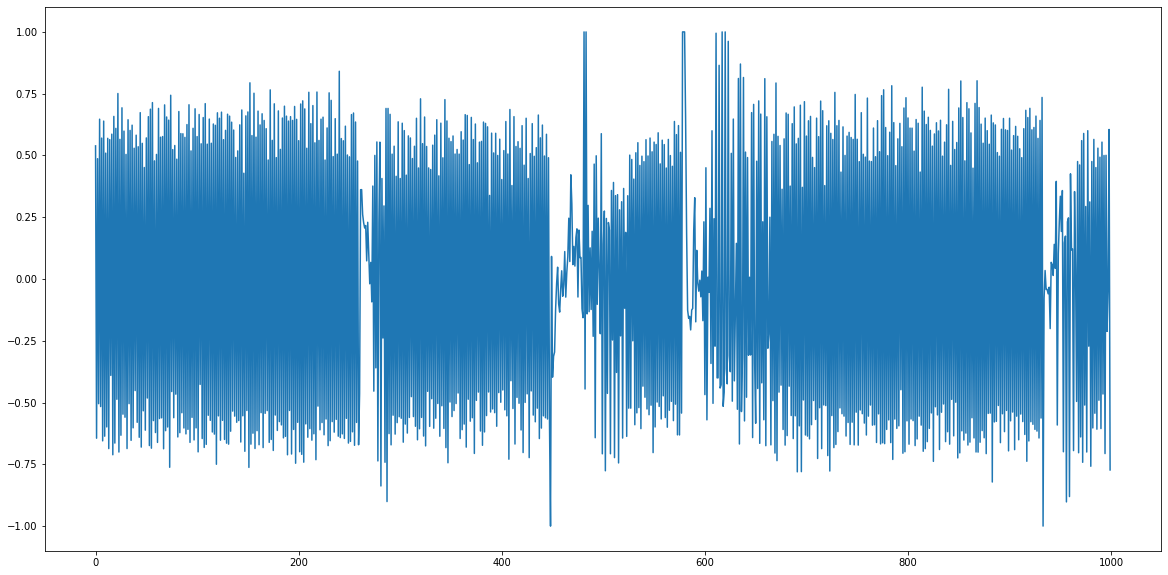

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(t1[-1000:])

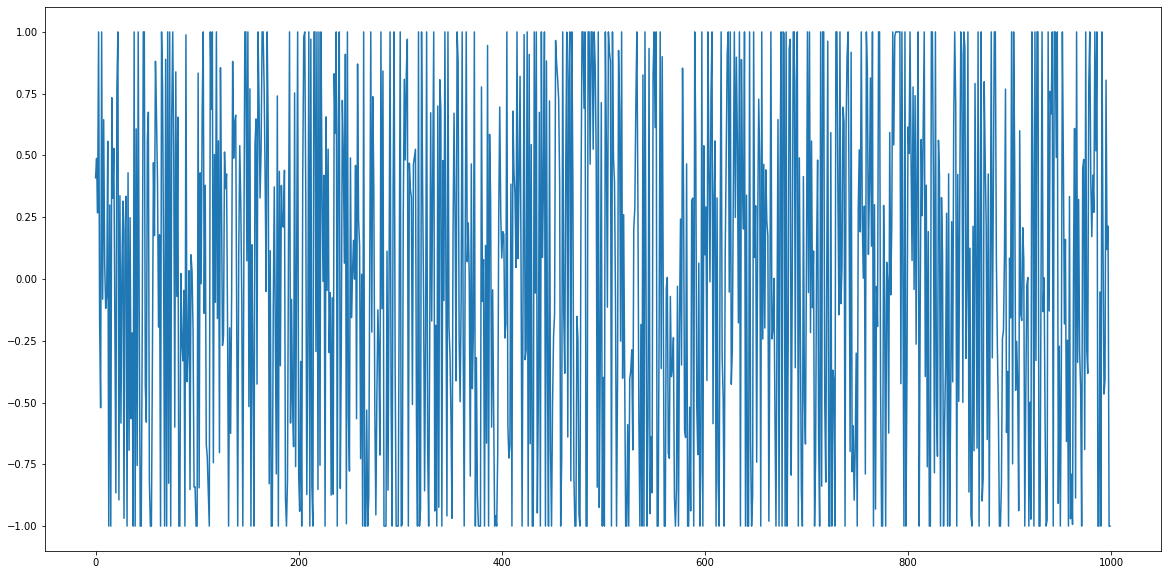

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(t2[:1000])

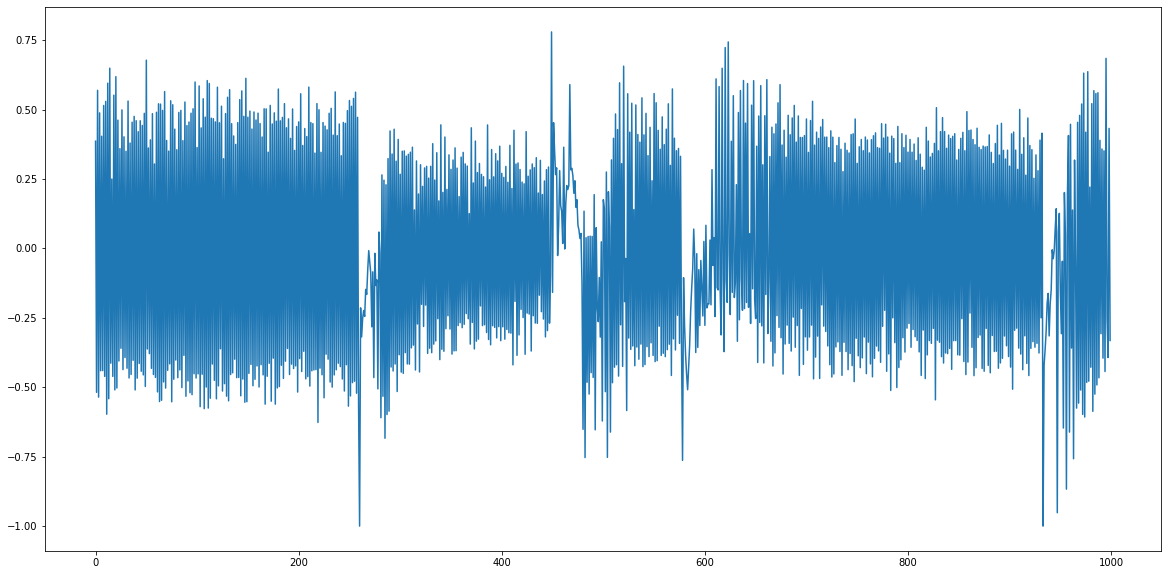

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(t2[-1000:])

In [16]:
pos = np.array(env.target_pos)
pos.shape
X = np.array(pos)

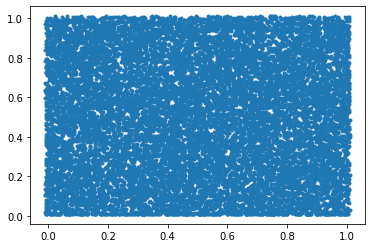

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[:,0], X[:,2],'.')

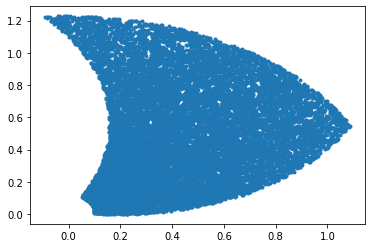

In [18]:
pos = np.array(env.ee_pos)
pos.shape
X = np.array(pos)
plt.figure()
plt.plot(X[:,0], X[:,1],'.')

## 2.4 Try a first learning episode to see... <a name="2.4"></a>

In [19]:
DT

0.002

## 2.5 Run the full training <a name="2.5"></a>

We prepare the set of random positions of the target :

In [7]:
import os, sys, time, shutil, yaml, pathlib, shutil
import pybullet as p
import pybullet_data
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from math import pi

from utils.tools import (is_close_to, move_to, display_joint_properties, 
                         test_training, sample_line, sample_traj4pts, get_files_by_date)
from utils.tools import welcome, plot_test, moving_average
from utils.RoboticArm_2DOF import RoboticArm_2DOF_PyBullet

In [24]:
if 'env' in dir(): env.close()

In [8]:
DT = 0.002

In [9]:
#if 'env' in dir(): env.close()

URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"
SEED = 1234567

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  headless = False, 
                                  max_episode_steps = 400,
                                  verbose=0)

#env.action_space.seed(1234)
#env.observation_space.seed(1234)


################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#  G: close/open the tabs
#  W: switch between solid/wireframe rendering
#  J: show/hide links & joints frames as RGB lines (with wireframe rendering actvated)
#  K: show/hide joints axis as black lines (with wireframe rendering actvated)
#  Q: quit PyBullet
#  CTRL+left_clic  : rotate the robot
#  CRTL+midlle_clic: translate the robot
#  Mouse_wheel: zoom/unzoom
################################################################################



In [25]:
#if 'env' in dir(): env.close()

URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"
SEED = 1234567

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  headless = True, 
                                  max_episode_steps = 400,
                                  verbose=0)

#env.action_space.seed(1234)
#env.observation_space.seed(1234)

In [3]:
model_dir= "./models/2DOF_RobotArm_PyBullet_PPO_22-09-26_17-56-23/"

In [4]:
training_dir= "./models/2DOF_RobotArm_PyBullet_PPO_22-09-26_17-56-23"

[top](#top)

In [27]:
! tensorboard --logdir "./models/2DOF_RobotArm_PyBullet_PPO_22-09-26_17-56-23/PPO_1/"

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [6]:
# Visualiser pour chaque entrainement .zip comment le bras se positionne sur
# la target

from stable_baselines3 import PPO as agent

files = os.listdir(model_dir + "/ZIP")
files.sort()

epsilon = 1e-3
max_steps = 200

for f in files:
    print(f)
    model = agent.load(model_dir + "ZIP/" + f)

    verbose=1
    obs = env.reset(options={"dt":DT, 
                             "target_initial_pos":(0.75, 0, 0.5),
                             "robot_initial_angle_deg":(113, -140),
                             "randomize":False,
                             "epsilon": epsilon})
    
    done, step_count, rewards, actions = False, 0, [], []
    while step_count < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            rewards.append(float(reward))
            actions.append(action)
            step_count += 1
            #time.sleep(env.dt)
            if is_close_to(np.array(env.effector_pos), np.array(env.actual_target_pos), 1e-3): break
            if verbose and (step_count % 10 == 0) : print("\r", step_count, end="")
    if verbose: print(" ...done!")
    if step_count == max_steps+1: step_count -= 1    
    input("press ENTER for next file....")
    

model.zip
 200 ...done!


KeyboardInterrupt: Interrupted by user

In [12]:
list_files = get_files_by_date(model_dir + "ZIP")
print(list_files)

['rl_model_100000_steps.zip', 'rl_model_200000_steps.zip', 'rl_model_300000_steps.zip', 'rl_model_400000_steps.zip', 'rl_model_500000_steps.zip', 'rl_model_600000_steps.zip', 'rl_model_700000_steps.zip', 'rl_model_800000_steps.zip', 'rl_model_900000_steps.zip', 'rl_model_1000000_steps.zip', 'rl_model_1100000_steps.zip', 'rl_model_1200000_steps.zip', 'rl_model_1300000_steps.zip', 'rl_model_1400000_steps.zip', 'rl_model_1500000_steps.zip', 'rl_model_1600000_steps.zip', 'rl_model_1700000_steps.zip', 'rl_model_1800000_steps.zip', 'rl_model_1900000_steps.zip', 'rl_model_2000000_steps.zip', 'rl_model_2100000_steps.zip', 'rl_model_2200000_steps.zip', 'rl_model_2300000_steps.zip', 'rl_model_2400000_steps.zip', 'rl_model_2500000_steps.zip', 'rl_model_2600000_steps.zip', 'rl_model_2700000_steps.zip', 'rl_model_2800000_steps.zip', 'rl_model_2900000_steps.zip', 'rl_model_3000000_steps.zip', 'rl_model_3100000_steps.zip', 'rl_model_3200000_steps.zip', 'rl_model_3300000_steps.zip', 'rl_model_3400000_

In [29]:
# on parcours les fichiers d'entrainement pour garder celui qui se positionne le mieux
# sur les 4 points définis.

verbose=0

q1_q2 = (113, -140)
epsilon = 2.e-3
env._max_episode_steps = None

err_mean  = 1e20
max_steps = 500

list_files = get_files_by_date(model_dir + "ZIP")

error = []

for i, file in enumerate(list_files):    
    
    print(file)
    res, err = [], []
    
    model = agent.load(model_dir + "ZIP/" + file)
    
    obs = env.reset(options={"dt": DT, 
                             "target_initial_pos": (0.5,0,0),
                             "robot_initial_angle_deg": q1_q2,
                             "randomize": False,
                             "epsilon": epsilon})    
    
    for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
        if verbose: print(f"\t {target_pos}", end="")
        env.set_target_position(np.array(target_pos))
        
        done, step_count, rewards, actions = False, 0, [], []
        while step_count < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            step_count += 1
            if done: break
        
        dist_effect_target = norm(np.array(env.effector_pos) - target_pos)
        err.append(dist_effect_target)
        if verbose: print(f" {step_count} steps, dist: {dist_effect_target*100:.2f} cm ")    

    e_mean = np.array(err).mean()
    e_std  = np.array(err).std()
    error.append(err)
    
    print(f"\t e_mean, e_std: {e_mean*100:6.2f}, {e_std*100:6.2f} cm")
    
    if e_mean < err_mean:
        best_train = file
        err_mean = e_mean
            
error = np.array(error)            
print(f"Best train: {best_train}, error: {err_mean*100:.2f} cm")    

rl_model_100000_steps.zip
	 e_mean, e_std:  79.26,  33.60 cm
rl_model_200000_steps.zip
	 e_mean, e_std:  55.57,  23.91 cm
rl_model_300000_steps.zip
	 e_mean, e_std:  24.75,  16.67 cm
rl_model_400000_steps.zip
	 e_mean, e_std:  10.90,   6.07 cm
rl_model_500000_steps.zip
	 e_mean, e_std:   8.06,   5.48 cm
rl_model_600000_steps.zip
	 e_mean, e_std:   5.48,   5.26 cm
rl_model_700000_steps.zip
	 e_mean, e_std:   6.71,   3.22 cm
rl_model_800000_steps.zip
	 e_mean, e_std:   9.22,   6.14 cm
rl_model_900000_steps.zip
	 e_mean, e_std:   3.78,   3.35 cm
rl_model_1000000_steps.zip
	 e_mean, e_std:   3.21,   3.11 cm
rl_model_1100000_steps.zip
	 e_mean, e_std:   5.67,   4.61 cm
rl_model_1200000_steps.zip
	 e_mean, e_std:   5.08,   3.93 cm
rl_model_1300000_steps.zip
	 e_mean, e_std:  16.64,  26.64 cm
rl_model_1400000_steps.zip
	 e_mean, e_std:   3.85,   1.61 cm
rl_model_1500000_steps.zip
	 e_mean, e_std:   3.65,   1.19 cm
rl_model_1600000_steps.zip
	 e_mean, e_std:   2.90,   1.59 cm
rl_model_1700000_

In [30]:
# on parcours les fichiers d'entrainement pour garder celui qui se positionne le mieux
# sur les 4 points définis.

verbose=0

q1_q2 = (113, -140)
epsilon = 1.e-3
env._max_episode_steps = None

err_mean = 1e20
max_steps_nb = 500

list_files = get_files_by_date(model_dir + "ZIP")

error = []

for i, file in enumerate(list_files):    
    
    print(file)
    res, err = [], []
    
    model = agent.load(model_dir + "ZIP/" + file)
    
    obs = env.reset(options={"dt": DT, 
                             "target_initial_pos": (0.5,0,0),
                             "robot_initial_angle_deg": q1_q2,
                             "randomize": False,
                             "epsilon": epsilon})    
    
    for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
        if verbose: print(f"\t {target_pos}", end="")
        env.set_target_position(np.array(target_pos))
        
        done, step_count, rewards, actions = False, 0, [], []
        while step_count < max_steps_nb:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            step_count += 1
            if done: break
        
        dist_effect_target = norm(np.array(env.effector_pos) - target_pos)
        err.append(dist_effect_target)
        if verbose: print(f" {step_count} steps, dist: {dist_effect_target*100:.2f} cm ")    

    e_mean = np.array(err).mean()
    e_std  = np.array(err).std()
    error.append(err)
    
    print(f"\t e_mean, e_std: {e_mean*100:6.2f}, {e_std*100:6.2f} cm")
    
    if e_mean < err_mean:
        best_train = file
        err_mean = e_mean
            
error = np.array(error)            
print(f"Best train: {best_train}, error: {err_mean*100:.2f} cm")    

rl_model_100000_steps.zip
	 e_mean, e_std:  79.26,  33.60 cm
rl_model_200000_steps.zip
	 e_mean, e_std:  55.57,  23.91 cm
rl_model_300000_steps.zip
	 e_mean, e_std:  24.75,  16.67 cm
rl_model_400000_steps.zip
	 e_mean, e_std:  10.90,   6.07 cm
rl_model_500000_steps.zip
	 e_mean, e_std:   8.06,   5.48 cm
rl_model_600000_steps.zip
	 e_mean, e_std:   5.48,   5.26 cm
rl_model_700000_steps.zip
	 e_mean, e_std:   6.71,   3.22 cm
rl_model_800000_steps.zip
	 e_mean, e_std:   9.22,   6.14 cm
rl_model_900000_steps.zip
	 e_mean, e_std:   3.78,   3.35 cm
rl_model_1000000_steps.zip
	 e_mean, e_std:   1.74,   1.61 cm
rl_model_1100000_steps.zip
	 e_mean, e_std:   5.67,   4.61 cm
rl_model_1200000_steps.zip
	 e_mean, e_std:   5.08,   3.93 cm
rl_model_1300000_steps.zip
	 e_mean, e_std:   4.24,   1.83 cm
rl_model_1400000_steps.zip
	 e_mean, e_std:   3.85,   1.61 cm
rl_model_1500000_steps.zip
	 e_mean, e_std:   3.65,   1.19 cm
rl_model_1600000_steps.zip
	 e_mean, e_std:   2.90,   1.59 cm
rl_model_1700000_

In [31]:
error.mean(axis=1).argmin()

42

In [32]:
error.mean(axis=1)[error.mean(axis=1).argmin()]

0.0036018228002558696

In [34]:
list_files[error.mean(axis=1).argmin()]

'rl_model_4300000_steps.zip'

In [35]:
e_mean = error.mean(axis=1)
L = np.where(e_mean < 0.01)

for i in L[0].tolist():
    print(f"{list_files[i]} -> {e_mean[i]*100:.2f} cm,"
          f"max: {error[i].max()*100:.2f} cm,"
          f"min: {error[i].min()*100:.2f} cm," 
          f"std: {error[i].std()*100:.2f} cm")

rl_model_2200000_steps.zip -> 0.69 cm,max: 2.73 cm,min: 0.06 cm,std: 1.04 cm
rl_model_4200000_steps.zip -> 0.74 cm,max: 1.09 cm,min: 0.60 cm,std: 0.18 cm
rl_model_4300000_steps.zip -> 0.36 cm,max: 1.12 cm,min: 0.09 cm,std: 0.40 cm
rl_model_4600000_steps.zip -> 0.82 cm,max: 1.71 cm,min: 0.08 cm,std: 0.72 cm
rl_model_4900000_steps.zip -> 0.98 cm,max: 1.46 cm,min: 0.09 cm,std: 0.48 cm


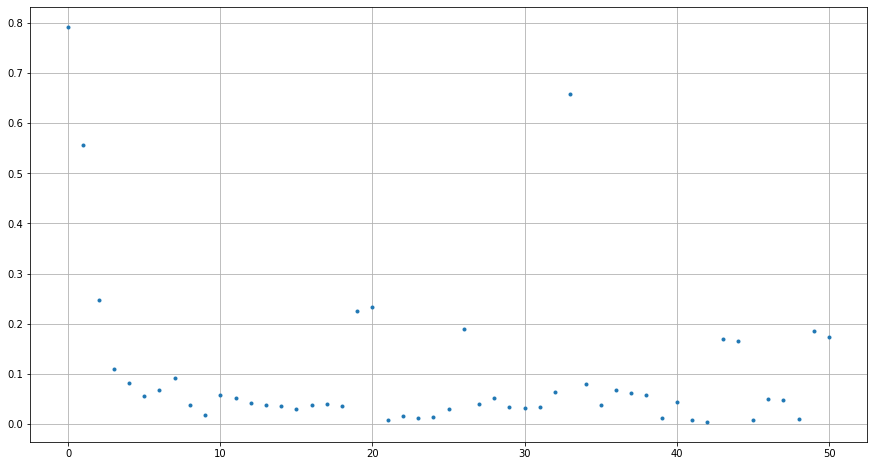

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(error.mean(axis=1),'.')
plt.grid()

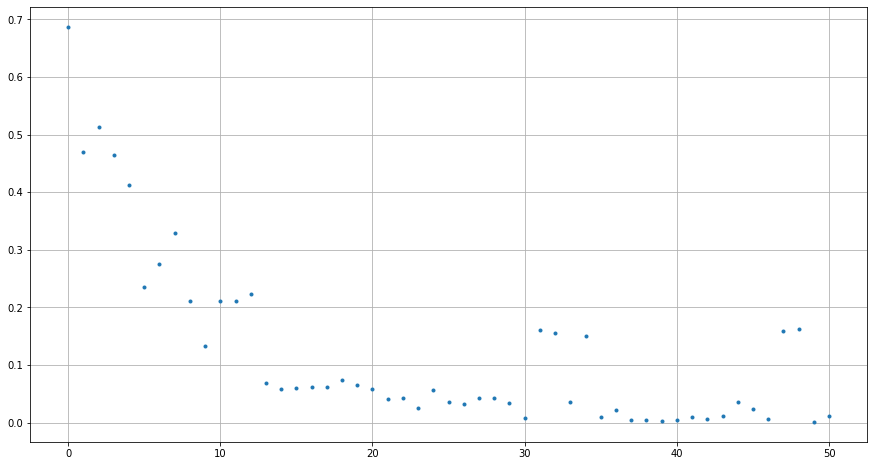

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(error.mean(axis=1),'.')
plt.grid()

evaluate

## perf pour un fichier donné

In [13]:
from stable_baselines3 import PPO as agent
model = agent.load(model_dir + "ZIP/rl_model_4300000_steps.zip")

In [14]:
try:
    env.close()
except:    
    del env

In [15]:
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"
SEED = 1234567

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  headless = False, 
                                  max_episode_steps = 400,
                                  verbose=0)

#env.action_space.seed(1234)
#env.observation_space.seed(1234)


################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#  G: close/open the tabs
#  W: switch between solid/wireframe rendering
#  J: show/hide links & joints frames as RGB lines (with wireframe rendering actvated)
#  K: show/hide joints axis as black lines (with wireframe rendering actvated)
#  Q: quit PyBullet
#  CTRL+left_clic  : rotate the robot
#  CRTL+midlle_clic: translate the robot
#  Mouse_wheel: zoom/unzoom
################################################################################



/home/jlc/work/miniconda3/envs/pyml38/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [16]:
# le bras doit atteindre la cible:

verbose=1
obs = env.reset(options={"dt":DT, 
                         "target_initial_pos":(0.75,0,0.5),
                         "robot_initial_angle_deg":(113, -140),
                         "randomize":False})
max_steps = 300
done, step_count, rewards, actions = False, 0, [], []
while step_count < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        rewards.append(float(reward))
        actions.append(action)
        step_count += 1
        time.sleep(env.dt)
        if is_close_to(np.array(env.effector_pos), np.array(env.actual_target_pos), 5e-3): break
        if verbose and (step_count % 10 == 0) : print("\r", step_count, end="")
if verbose: print(" ...done!")
if step_count == max_steps+1: step_count -= 1

 70 ...done!


In [17]:
# Le bras parcours la trajetoire fermée définie par 4 points

verbose=1
q1_q2 = (113, -140)
epsilon = 1.e-3
max_steps = 500

env._max_episode_steps = None
obs = env.reset(options={"dt": DT, 
                         "target_initial_pos": (0.5,0,0),
                         "robot_initial_angle_deg": q1_q2,
                         "randomize": False,
                         "epsilon": epsilon})

for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
    if verbose: print(target_pos)
    t0 = time.time()
    env.set_target_position(np.array(target_pos))    
    done, printDone, step_count, rewards, actions = False, False, 0, [], []
    while step_count < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action)
        if not done:
            obs, reward, done, info = env.step(action)
            rewards.append(float(reward))
        step_count += 1
        time.sleep(env.dt)
        if verbose: 
            if not done: 
                print("\r", step_count, end="")
            elif not printDone: 
                print("...done!", end="")
                printDone = True
    t1 = time.time()
    if verbose:
        if not done: print("...not done!", end="")
        print(f" in {t1 - t0:.1f} sec.")


(0.5, 0.0, 0.02)
 173...done! in 1.5 sec.
(1, 0, 0.5)
 500...not done! in 1.8 sec.
(0.5, 0, 1)
 500...not done! in 1.7 sec.
(0, 0, 0.5)
 187...done! in 1.5 sec.
(0.5, 0, 0.02)
 213...done! in 1.5 sec.


In [20]:
file = "rl_model_4300000_steps.zip"

In [21]:
# Pour un fichier donné, on balaye plusieurs valeurs de numSubSteps, et pour chaque, 
# le bras parcours la trajetoire fermée définie par 4 points

verbose   = 0
q1_q2     = (113, -140)
err_mean  = 1e20

epsilon   = 1.e-3
max_steps = 300

error = []

model = agent.load(os.path.join(model_dir, "ZIP", file))
env._max_episode_steps = None

for nSubSteps in range(1, 101, 1):    
    
    print(f">>> nSubStep: {nSubSteps:4d}", end="")
    err = []
    
    obs = env.reset(options={"dt": DT, 
                             "target_initial_pos": (0.5,0,0),
                             "robot_initial_angle_deg": q1_q2,
                             "randomize": False,
                             "epsilon": epsilon,
                             "numSubSteps": nSubSteps})

    for target_pos in ((0.5,0.,0.02), (1,0,0.5), (0.5,0,1), (0,0,0.5), (0.5,0,0.02)):
        
        if verbose: print(f"\t {target_pos}", end="")
        env.set_target_position(np.array(target_pos))
                  
        done, step_count, rewards, actions = False, 0, [], []
        while step_count < max_steps:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            step_count += 1
            if done: break
      
        dist_effect_target = norm(np.array(env.effector_pos) - target_pos)
        err.append(dist_effect_target)
        if verbose: print(f"\t {step_count:3d} steps, dist: {dist_effect_target*100:.2f} cm ")    

    e_mean = np.array(err).mean()
    e_std  = np.array(err).std()
    error.append(err)

    print(f"\t e_mean:{e_mean*100:7.2f} cm, e_std:{e_std*100:7.2f} cm")
    
    if e_mean < err_mean:
        best_nSubSteps = nSubSteps
        err_mean = e_mean
            
error = np.array(error)            
print(f"Best nSubStep: {best_nSubSteps}, error: {err_mean*100:.2f} cm")              

>>> nSubStep:    1	 e_mean:   1.03 cm, e_std:   0.28 cm
>>> nSubStep:    2	 e_mean:   0.80 cm, e_std:   0.40 cm
>>> nSubStep:    3	 e_mean:   1.14 cm, e_std:   0.32 cm
>>> nSubStep:    4	 e_mean:   0.71 cm, e_std:   0.36 cm
>>> nSubStep:    5	 e_mean:   1.05 cm, e_std:   0.10 cm
>>> nSubStep:    6	 e_mean:   0.97 cm, e_std:   0.14 cm
>>> nSubStep:    7	 e_mean:   1.04 cm, e_std:   0.10 cm
>>> nSubStep:    8	 e_mean:   0.97 cm, e_std:   0.13 cm
>>> nSubStep:    9	 e_mean:   1.01 cm, e_std:   0.12 cm
>>> nSubStep:   10	 e_mean:   1.00 cm, e_std:   0.15 cm
>>> nSubStep:   11	 e_mean:   0.93 cm, e_std:   0.11 cm
>>> nSubStep:   12	 e_mean:   1.00 cm, e_std:   0.11 cm
>>> nSubStep:   13	 e_mean:   0.94 cm, e_std:   0.09 cm
>>> nSubStep:   14	 e_mean:   0.97 cm, e_std:   0.10 cm
>>> nSubStep:   15	 e_mean:   0.93 cm, e_std:   0.08 cm
>>> nSubStep:   16	 e_mean:   0.92 cm, e_std:   0.09 cm
>>> nSubStep:   17	 e_mean:   0.93 cm, e_std:   0.10 cm
>>> nSubStep:   18	 e_mean:   0.57 cm, e_std:   

In [22]:
error.mean(axis=1).argmin()

47

In [23]:
error.mean(axis=1)[41]

0.0044285207801452

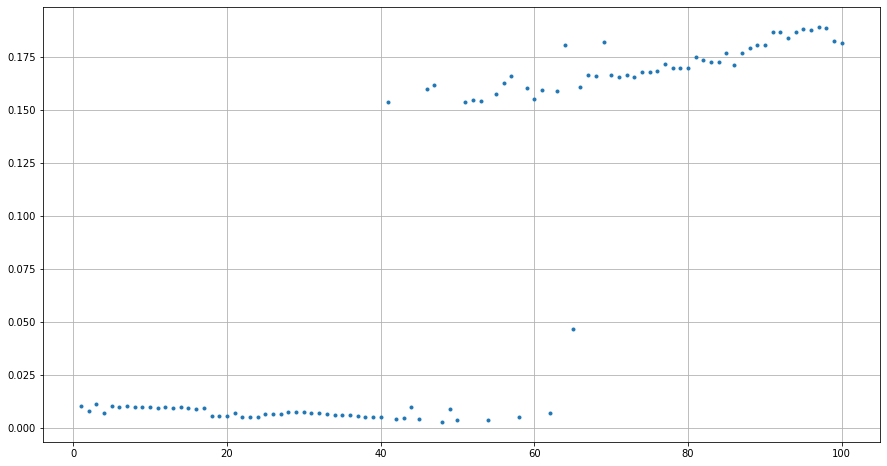

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(range(1, 101, 1), error.mean(axis=1),'.')
plt.grid()

In [118]:
# pour un fichier model donné et un nbSubSteps donné,
# regarder les nb_pts_per_line et max_tries optimaux:

from stable_baselines3 import PPO as agent

results, err_mean = {}, 1e20
p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)
trajectory = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))

epsilon = 1.e-3
nbSubSteps = 27

model = agent.load(os.path.join(model_dir, "ZIP", file))
env._max_episode_steps = None

for nb_pts_per_line in range(20, 105, 5):
    pts, dl = sample_traj4pts(trajectory, nb_pts_per_line)
    for max_step_nb in range(20, 95, 5):
        print(f"\n>>> nb_pts:{nb_pts_per_line:3d}, max_step_nb:{max_step_nb:3d}")
        err = test_training(model, env, DT, pts, max_step_nb, epsilon, nbSubSteps)
        e_mean = err.mean()
        results[(nb_pts_per_line, max_step_nb)] = (file, e_mean, err)
        if e_mean < err_mean:
            n = nb_pts_per_line
            m = max_step_nb
            best_train = file
            err_mean = e_mean
            
print(f"best train for nbSubSteps {nbSubSteps}, error: {err_mean}, (nb_pts, max_step_nb): {n, m}")


>>> nb_pts: 20, max_step_nb: 20
15, 
e_av: 0.0409, e_std:0.0203, abs(e)_max: 0.1040

>>> nb_pts: 20, max_step_nb: 25

e_av: 0.0335, e_std:0.0197, abs(e)_max: 0.1092

>>> nb_pts: 20, max_step_nb: 30
28, 29, 24, 
e_av: 0.0304, e_std:0.0180, abs(e)_max: 0.0935

>>> nb_pts: 20, max_step_nb: 35
35, 21, 31, 18, 
e_av: 0.0286, e_std:0.0179, abs(e)_max: 0.1087

>>> nb_pts: 20, max_step_nb: 40
39, 31, 27, 39, 33, 30, 32, 11, 27, 9, 
e_av: 0.0264, e_std:0.0179, abs(e)_max: 0.1136

>>> nb_pts: 20, max_step_nb: 45
18, 41, 27, 29, 30, 19, 18, 20, 
e_av: 0.0253, e_std:0.0169, abs(e)_max: 0.1050

>>> nb_pts: 20, max_step_nb: 50
10, 50, 43, 49, 34, 50, 18, 50, 38, 38, 31, 34, 50, 41, 38, 
e_av: 0.0237, e_std:0.0159, abs(e)_max: 0.0836

>>> nb_pts: 20, max_step_nb: 55
44, 51, 43, 41, 36, 38, 46, 39, 54, 45, 44, 36, 28, 
e_av: 0.0227, e_std:0.0160, abs(e)_max: 0.1040

>>> nb_pts: 20, max_step_nb: 60
10, 43, 38, 57, 41, 52, 40, 29, 29, 34, 38, 55, 60, 59, 57, 43, 43, 55, 30, 40, 48, 29, 34, 
e_av: 0.022

In [119]:
# pour un fichier model donné et un nbSubSteps donné,
# regarder les nb_pts_per_line et max_tries optimaux:

from stable_baselines3 import PPO as agent

results, err_mean = {}, 1e20
p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)
trajectory = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))

epsilon = 1.e-3
nbSubSteps = 35

model = agent.load(os.path.join(model_dir, "ZIP", file))
env._max_episode_steps = None

for nb_pts_per_line in range(20, 105, 5):
    pts, dl = sample_traj4pts(trajectory, nb_pts_per_line)
    for max_step_nb in range(20, 65, 5):
        print(f"\n>>> nb_pts:{nb_pts_per_line:3d}, max_step_nb:{max_step_nb:3d}")
        err = test_training(model, env, DT, pts, max_step_nb, epsilon, nbSubSteps)
        e_mean = err.mean()
        results[(nb_pts_per_line, max_step_nb)] = (file, e_mean, err)
        if e_mean < err_mean:
            n = nb_pts_per_line
            m = max_step_nb
            best_train = file
            err_mean = e_mean
            
print(f"best train for nbSubSteps {nbSubSteps}, error: {err_mean}, (nb_pts, max_step_nb): {n, m}")


>>> nb_pts: 20, max_step_nb: 20

e_av: 0.0426, e_std:0.0208, abs(e)_max: 0.1066

>>> nb_pts: 20, max_step_nb: 25
21, 
e_av: 0.0360, e_std:0.0183, abs(e)_max: 0.0970

>>> nb_pts: 20, max_step_nb: 30
22, 
e_av: 0.0314, e_std:0.0167, abs(e)_max: 0.0945

>>> nb_pts: 20, max_step_nb: 35
31, 35, 30, 33, 
e_av: 0.0291, e_std:0.0158, abs(e)_max: 0.0750

>>> nb_pts: 20, max_step_nb: 40
20, 31, 31, 39, 40, 
e_av: 0.0268, e_std:0.0152, abs(e)_max: 0.0837

>>> nb_pts: 20, max_step_nb: 45
39, 43, 29, 29, 19, 44, 19, 
e_av: 0.0243, e_std:0.0147, abs(e)_max: 0.0978

>>> nb_pts: 20, max_step_nb: 50
47, 48, 43, 50, 37, 36, 29, 38, 
e_av: 0.0231, e_std:0.0140, abs(e)_max: 0.0723

>>> nb_pts: 20, max_step_nb: 55
46, 53, 50, 26, 53, 41, 53, 
e_av: 0.0222, e_std:0.0142, abs(e)_max: 0.0721

>>> nb_pts: 20, max_step_nb: 60
55, 56, 47, 54, 47, 58, 50, 28, 45, 29, 
e_av: 0.0216, e_std:0.0141, abs(e)_max: 0.0722

>>> nb_pts: 25, max_step_nb: 20

e_av: 0.0373, e_std:0.0169, abs(e)_max: 0.0870

>>> nb_pts: 25, m

In [ ]:
# pour un fichier model donné et un nbSubSteps donné,
# regarder les nb_pts_per_line et max_tries optimaux:

from stable_baselines3 import PPO as agent

results, err_mean = {}, 1e20
p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)
trajectory = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))

epsilon = 1.e-3
nbSubSteps = 50

model = agent.load(os.path.join(model_dir, "ZIP", file))
env._max_episode_steps = None

for nb_pts_per_line in range(20, 105, 5):
    pts, dl = sample_traj4pts(trajectory, nb_pts_per_line)
    for max_step_nb in range(20, 65, 5):
        print(f"\n>>> nb_pts:{nb_pts_per_line:3d}, max_step_nb:{max_step_nb:3d}")
        err = test_training(model, env, DT, pts, max_step_nb, epsilon, nbSubSteps)
        e_mean = err.mean()
        results[(nb_pts_per_line, max_step_nb)] = (file, e_mean, err)
        if e_mean < err_mean:
            n = nb_pts_per_line
            m = max_step_nb
            best_train = file
            err_mean = e_mean
            
print(f"best train for nbSubSteps {nbSubSteps}, error: {err_mean}, (nb_pts, max_step_nb): {n, m}")

best train for nbSubSteps 50, error: 0.011388370668777537, (nb_pts, max_step_nb): (100, 50)

In [ ]:
# pour un fichier model donné et un nbSubSteps donné,
# regarder les nb_pts_per_line et max_tries optimaux:

from stable_baselines3 import PPO as agent

results, err_mean = {}, 1e20
p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)
trajectory = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))

epsilon = 1.e-3
nbSubSteps = 75

model = agent.load(os.path.join(model_dir, "ZIP", file))
env._max_episode_steps = None

for nb_pts_per_line in range(20, 105, 5):
    pts, dl = sample_traj4pts(trajectory, nb_pts_per_line)
    for max_step_nb in range(20, 65, 5):
        print(f"\n>>> nb_pts:{nb_pts_per_line:3d}, max_step_nb:{max_step_nb:3d}")
        err = test_training(model, env, DT, pts, max_step_nb, epsilon, nbSubSteps)
        e_mean = err.mean()
        results[(nb_pts_per_line, max_step_nb)] = (file, e_mean, err)
        if e_mean < err_mean:
            n = nb_pts_per_line
            m = max_step_nb
            best_train = file
            err_mean = e_mean
            
print(f"best train for nbSubSteps {nbSubSteps}, error: {err_mean}, (nb_pts, max_step_nb): {n, m}")

\>>> nb_pts:100, max_step_nb: 60
26, 7, 41, 10, 
e_av: 0.0311, e_std:0.0191, abs(e)_max: 0.0839
best train for nbSubSteps 75, error: 0.02336186926640777, (nb_pts, max_step_nb): (80, 55)

In [ ]:
try:
    env.close()
except:    
    del env

In [7]:
if 'env' in dir(): env.close()
SEED = 1234567
URDF   = "./urdf/RoboticArm_2DOF_2.urdf"
TARGET = "./urdf/target.urdf"

env    = RoboticArm_2DOF_PyBullet(robot_urdf  = URDF, 
                                  target_urdf = TARGET, 
                                  dt = DT,
                                  init_robot_angles = (113, -140),
                                  reward = 'reward_0',
                                  seed = SEED,
                                  headless = False, 
                                  max_episode_steps = None,
                                  verbose=0)

#env.action_space.seed(1234)
#env.observation_space.seed(1234)


################################################################################
# Welcome to this practical session with Pybullet & URDF.
# Pybullet windows shortcuts:
#  G: close/open the tabs
#  W: switch between solid/wireframe rendering
#  J: show/hide links & joints frames as RGB lines (with wireframe rendering actvated)
#  K: show/hide joints axis as black lines (with wireframe rendering actvated)
#  Q: quit PyBullet
#  CTRL+left_clic  : rotate the robot
#  CRTL+midlle_clic: translate the robot
#  Mouse_wheel: zoom/unzoom
################################################################################



/home/jlc/work/miniconda3/envs/pyml38/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [123]:
file = "rl_model_5000000_steps.zip"

In [5]:
file = "rl_model_4300000_steps.zip"

In [9]:
from stable_baselines3 import PPO as agent

results, err_mean = {}, 1e20

epsilon = 1.e-3
nbSubSteps = 50
nb_pts_per_line = 100
max_step_nb = 50

p1, p2, p3, p4 = (0.5, 0.02), (1, 0.5), (0.5, 1), (0, 0.5)
trajectory = ((p2, p3), (p3, p4), (p4, p1), (p1, p2))
pts, dl = sample_traj4pts(trajectory, nb_pts_per_line)

model = agent.load(os.path.join(model_dir, "ZIP", file))

err = test_training(model, env, DT, pts, max_step_nb, epsilon, nbSubSteps)

49, 46, 50, 46, 44, 42, 40, 42, 38, 40, 36, 38, 34, 38, 34, 39, 29, 39, 27, 39, 25, 35, 23, 26, 24, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 20, 22, 20, 20, 20, 20, 
e_av: 0.0076, e_std:0.0031, abs(e)_max: 0.0182


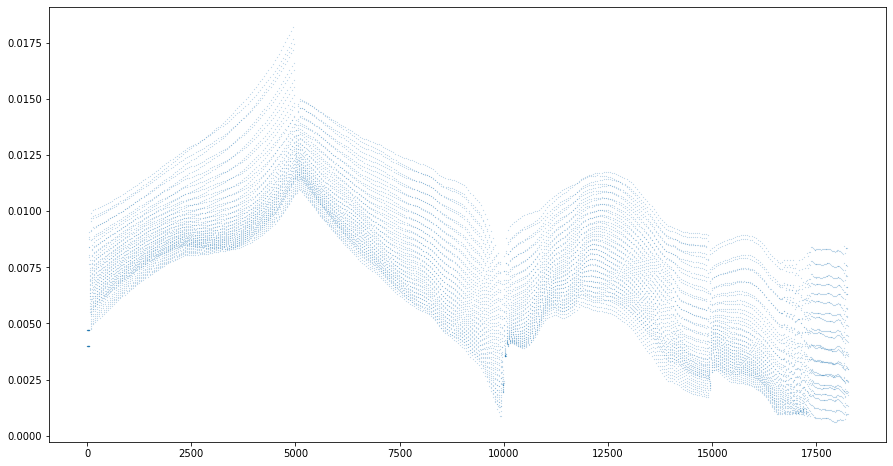

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(err,'.', markersize=0.2)

In [29]:
t1=np.array(env.torque1)
t2=np.array(env.torque2)

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(t1)

NameError: name 't1' is not defined

<Figure size 1440x720 with 0 Axes>

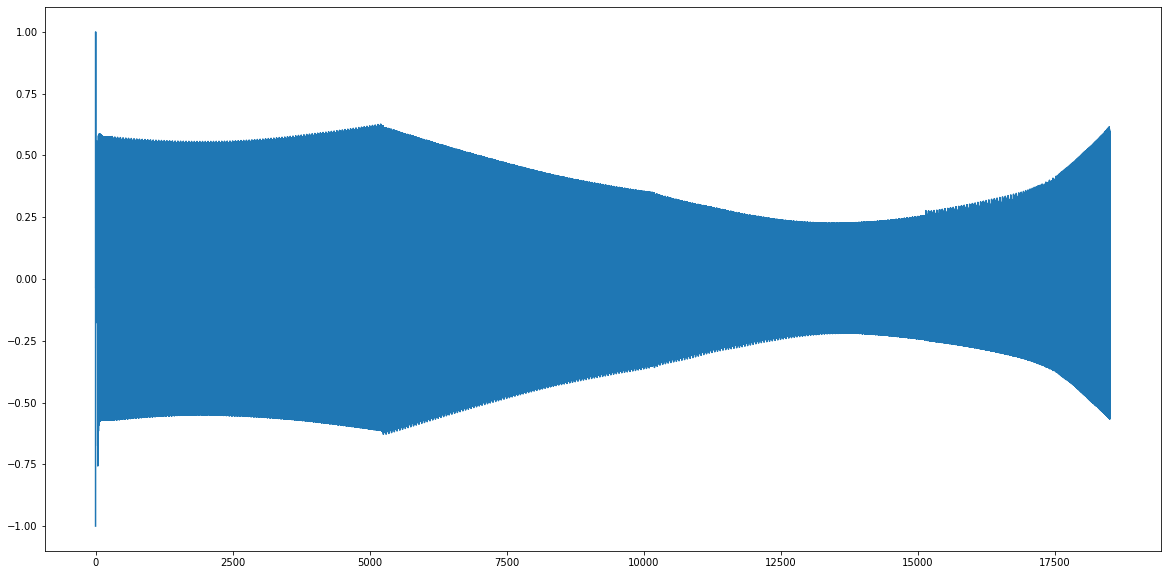

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(t2)

In [132]:
env.close()

# enregistrer le notebook !!!!

In [129]:
training_dir = pathlib.Path('./models/2DOF_RobotArm_PyBullet_PPO_22-09-18_14-19-02/')

In [130]:
# copy precious files in experiment_dir
for file in ('./train_the_robot_with_DRL.ipynb', 'rewards.py', './utils/RoboticArm_2DOF.py', './urdf/RoboticArm_2DOF_2.urdf'):
    base = os.path.basename(file)
    shutil.copyfile(file, os.path.join(training_dir, base))

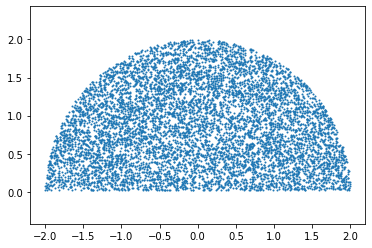

In [131]:
points = []
for _ in range(10000):
    x = np.random.uniform(-2., 2.)
    y = np.random.uniform(0.02, 2.)
    if x**2 + y**2 <= 4: points.append((x,y))
points = np.array(points)

fig, axe = plt.subplots(1,1)
axe.axis('equal')
axe.scatter(points[:,0], points[:,1], 1)